---
## Problem Statement

My goal is to visualize patterns or trends in the rapidly developing language of the online world. In this day and age, where discussions take place more and more in the digital format, I hope to take advantage of the vast amount of data available online regarding how people use language. Specifically, my domain of research will be focused on observing the social and cultural language trends of the popular online community **Reddit**.

- `r/philosophy` is a fourm where people share and discuss morals, ethics, and social observations made by prominent figures in the philosophical research community.
- `r/showerthoughts` is a forum where people voice their realizations or epiphanies that they have discovered independently of academic/scientific research.

With the language data of these two **Reddit** forums at my disposal, the question I hope to answer is:
- **Is there a difference between our own self-made observations and those made by established philosophers?**

I will scrape the new posts (via the `Reddit API` and `Python` scripting) to create a data set that will allow me to effectively visualize potential patterns of speech.
I hope to deliver a **classification** model which accurately identifies the subreddit in which a piece of language was taken from. I will evaluate several types of classification models based on a variety of metrics, with a focus on high **accuracy** (*above 85%*). 

---
## Exploratory Data Analysis

**We will begin by observing the data collected from both r/philosophy and r/showerthoughts.**

- Our analysis is using the titles of posts collected from each subreddit, as this is where the language is most succinct.

- The goal of this section is to ensure we have collected our data properly, as well as ensuring it is in the proper format to be processed by our models.

- Analyzing our data is helpful in spotting potential patterns/trends in the language. This can be useful for making insights that can already help us achieve the goals of our problem statement, as well as increase the performance of our production model.

---
### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# SciKit-Learn
from sklearn.feature_extraction.text import CountVectorizer

---
### Load Data

- Over a four day period, I was able to collect more than 1700 post titles in total across both subreddits using a python script to automate the process.

In [3]:
reddit_titles = pd.read_csv('../data/subreddit_data.csv')
print(f'{reddit_titles.shape[0]} total observations')

1775 total observations


In [4]:
reddit_titles.head(10)

,title,ID,subreddit
0,Jonathan Rée · No Foreigners: on Derrida’s Hos...,t3_1fw1nkf,philosophy
1,Introspection is a dangerous trap which lures ...,t3_1fvuxbl,philosophy
2,The True and the Good: A Strong Virtue Theory ...,t3_1fvrkf1,philosophy
3,Perhaps a major stepping stone to the good lif...,t3_1fvc7cb,philosophy
4,"""Humans understand the world more easily throu...",t3_1fv5d7d,philosophy
5,Why Christian Methodological Platonism (CMP) O...,t3_1fueady,philosophy
6,Philosophy is an erotic endeavour. | Plato's E...,t3_1fucl3c,philosophy
7,"Leibniz on Possibilia, Creation, and the Reali...",t3_1fu97nj,philosophy
8,Kant and Baumgarten on the Duty of Self-Love,t3_1ftgign,philosophy
9,/r/philosophy Open Discussion Thread | Septemb...,t3_1fsw8za,philosophy


In [5]:
# Quick overview.
reddit_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1775 non-null   object
 1   ID         1775 non-null   object
 2   subreddit  1775 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


In [6]:
# Double checking for missing values.
reddit_titles.isna().sum()

title        0
ID           0
subreddit    0
dtype: int64

In [7]:
# Checking how many total posts I was able to retrieve from each subreddit.
reddit_titles['subreddit'].value_counts()

subreddit
Showerthoughts    1012
philosophy         763
Name: count, dtype: int64

- r/philosophy does not have as high a post rate as r/Showerthoughts, I was expecting some imbalance and I feel it's just enough to make this interesting.

- I will need to account for this imbalance by stratifying my train test splits in part 2.

In [8]:
# Reading a few titles from each subreddit.
for title in reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title'][:5]:
    print(title)

print('==='*30)

for title in reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title'][:5]:
    print(title)

Jonathan Rée · No Foreigners: on Derrida’s Hospitality
Introspection is a dangerous trap which lures us with the illusion of self-knowledge but often leads to anxiety, confusion, and even depression. As Nietzsche noted, it's a futile loop: using the self to uncover the self only deepens the cycle of endless questioning. 
The True and the Good: A Strong Virtue Theory of the Value of Truth
Perhaps a major stepping stone to the good life isn’t striving for moral or material perfection; perhaps it’s simply taking a breath, going for a walk, and being a bit easier on ourselves in our imaginations | Epicurus on the Arduous Task of Untroubling the Mind
"Humans understand the world more easily through stories than philosophical arguments. But instead of saying we should only tell stories or only do philosophy, we ought to teach people how to do both in the best possible way!" -Margaret Atwood on fiction vs philosophy.
Words are like items: the rich have many and rare ones, while the poor often

In [9]:
# I'd like to explore the title lengths first just to get a better idea of what I'm working with.
reddit_titles['title_length'] = [len(title) for title in reddit_titles['title']]
reddit_titles.sort_values(by = 'title_length', ascending = False).head(5)

,title,ID,subreddit,title_length
1229,"What are the chances that, in open-world games...",t3_1e4pdg6,Showerthoughts,300
1050,TV started as a system where companies picked ...,t3_1eb59kh,Showerthoughts,298
1002,There should be a Vehicle version of the Libra...,t3_1fwhllu,Showerthoughts,296
856,If you start counting out loud as fast as you ...,t3_1ekbfic,Showerthoughts,296
601,An unaddressed factor in the increase in schoo...,t3_1ffi8lr,Showerthoughts,292


In [10]:
# Calculating the word count of each title by splitting at each white space.
reddit_titles['title_word_count'] = [len(title.split()) for title in reddit_titles['title']]
reddit_titles.sort_values(by = 'title_word_count', ascending = False).head(5)

,title,ID,subreddit,title_length,title_word_count
856,If you start counting out loud as fast as you ...,t3_1ekbfic,Showerthoughts,296,59
1257,The security guard in FNaF could just leave th...,t3_1e3r4vu,Showerthoughts,291,53
1229,"What are the chances that, in open-world games...",t3_1e4pdg6,Showerthoughts,300,52
1050,TV started as a system where companies picked ...,t3_1eb59kh,Showerthoughts,298,52
1002,There should be a Vehicle version of the Libra...,t3_1fwhllu,Showerthoughts,296,52


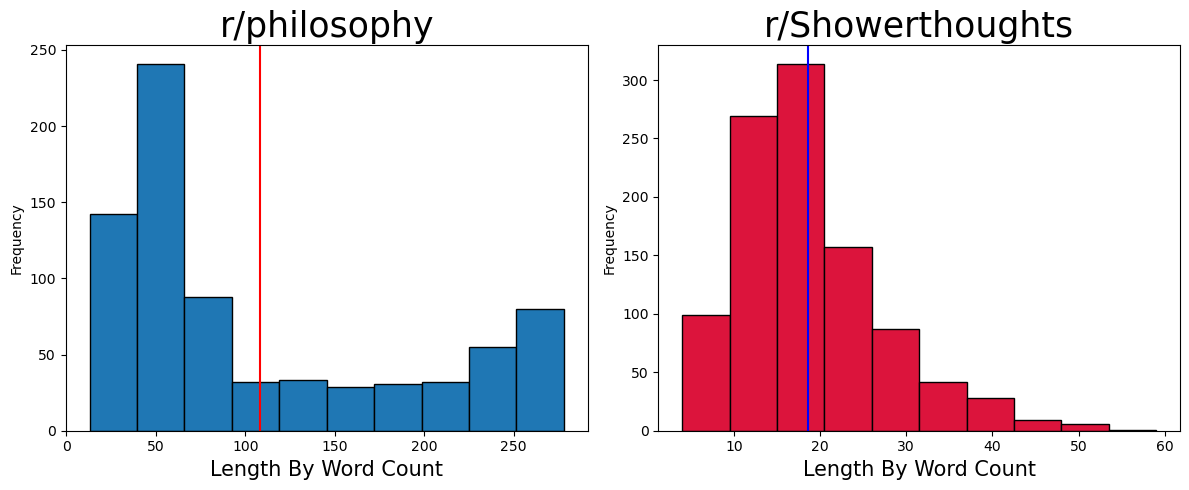

In [24]:
# Creating plots of results above for philosophy subreddit specifically.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# Plotting first distribution of title character count.
ax1.hist(reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title_length'], edgecolor = 'black')

ax1.set_title('r/philosophy', size = 25)
ax1.set_xlabel('Length By Word Count', size = 15)
ax1.set_ylabel('Frequency')

# Plotting the average title length as vertical line.
ax1.axvline(x = np.mean(reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title_length']), color = 'red')

# Plotting second distribution of title word count.
ax2.hist(reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title_word_count'], color='crimson', edgecolor = 'black');

ax2.set_title('r/Showerthoughts', size = 25)
ax2.set_xlabel('Length By Word Count', size = 15)
ax2.set_ylabel('Frequency')

# Average word count plotted as a vertical blue line.
ax2.axvline(x = np.mean(reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title_word_count']), color = 'blue')

plt.tight_layout()
plt.savefig('../images/word_count_comparison.png')
plt.show();

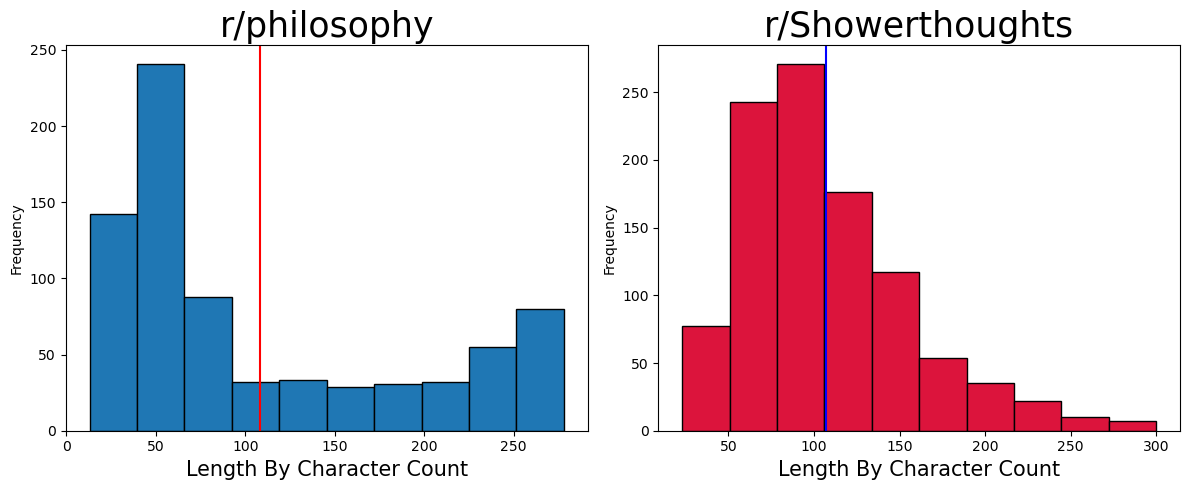

In [25]:
# Now plotting r/Showerthoughts title length distributions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# Plotting first distribution of title character count.
ax1.hist(reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title_length'], edgecolor = 'black')

ax1.set_title('r/philosophy', size = 25)
ax1.set_xlabel('Length By Character Count', size = 15)
ax1.set_ylabel('Frequency')

# Plotting the average title length as vertical line.
ax1.axvline(x = np.mean(reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title_length']), color = 'red')

# Plotting second distribution of title word count.
ax2.hist(reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title_length'], color='crimson', edgecolor = 'black');

ax2.set_title('r/Showerthoughts', size = 25)
ax2.set_xlabel('Length By Character Count', size = 15)
ax2.set_ylabel('Frequency')

# Average word count plotted as a vertical blue line.
ax2.axvline(x = np.mean(reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title_length']), color = 'blue')

plt.tight_layout()
plt.savefig('../images/char_count_comparison.png')
plt.show();

- While both subreddits share similar averages, the distributions show to me that titles in r/Showerthoughts are more frequently long, compared to r/philosophy.

---
### Tokenization & lemmatization of our post titles
- I'd like to create some new columns with the post title broken down further by process of tokenization, we can then remove stop words or convert the words of each post to their base form by lemmatizing.

In [13]:
# Word Tokenizing
reddit_titles['title_tokens'] = [word_tokenize(title.lower()) for title in reddit_titles['title']]

In [14]:
# Lemmatizing our tokens usually doesn't change much for most words but will help reducing the dimensionality of our word matrices
lemmatizer = WordNetLemmatizer()
title_lemms = []
for title in reddit_titles['title_tokens']:
    # removing stop words in the same stroke.
    title_lemms.append(' '.join([lemmatizer.lemmatize(token) for token in title if token not in stopwords.words('english')]))

reddit_titles['title_lemmatized'] = title_lemms

# Even though I am not 100% sure if I have need of these extra feature columns moving forward, they are fundamental NLP techniques I would like to display.
reddit_titles.head(5)

,title,ID,subreddit,title_length,title_word_count,title_tokens,title_lemmatized
0,Jonathan Rée · No Foreigners: on Derrida’s Hos...,t3_1fw1nkf,philosophy,54,8,"[jonathan, rée, ·, no, foreigners, :, on, derr...",jonathan rée · foreigner : derrida ’ hospitality
1,Introspection is a dangerous trap which lures ...,t3_1fvuxbl,philosophy,267,43,"[introspection, is, a, dangerous, trap, which,...",introspection dangerous trap lure u illusion s...
2,The True and the Good: A Strong Virtue Theory ...,t3_1fvrkf1,philosophy,67,14,"[the, true, and, the, good, :, a, strong, virt...",true good : strong virtue theory value truth
3,Perhaps a major stepping stone to the good lif...,t3_1fvc7cb,philosophy,262,46,"[perhaps, a, major, stepping, stone, to, the, ...",perhaps major stepping stone good life ’ striv...
4,"""Humans understand the world more easily throu...",t3_1fv5d7d,philosophy,269,44,"[``, humans, understand, the, world, more, eas...",`` human understand world easily story philoso...


---
### Exploring most frequent words by subreddit

In [15]:
# Instantiating a count vectorizer for each subreddit, choosing to remove stop words
cvec1 = CountVectorizer(stop_words = 'english')
cvec2 = CountVectorizer(stop_words = 'english')

showerthoughts_cvec = cvec1.fit_transform(reddit_titles[reddit_titles['subreddit'] == 'Showerthoughts']['title'])
philosophy_cvec = cvec2.fit_transform(reddit_titles[reddit_titles['subreddit'] == 'philosophy']['title'])

# Turning the sparse word matrix into a prettier dataframe with .todense() and .get_feature_names_out()
showerthoughts_cvec_df = pd.DataFrame(showerthoughts_cvec.todense(), columns = cvec1.get_feature_names_out())
philosophy_cvec_df = pd.DataFrame(philosophy_cvec.todense(), columns = cvec2.get_feature_names_out())

In [16]:
# Observing word frequencies of showerthoughts
word_counts_showerthoughts = pd.DataFrame(showerthoughts_cvec_df.sum(axis = 0), index = showerthoughts_cvec_df.columns, columns = ['Frequency'])

top_words_showerthoughts = word_counts_showerthoughts.sort_values(by = 'Frequency', ascending = False)[:20]
top_words_showerthoughts

,Frequency
people,142
probably,100
time,78
like,66
just,47
humans,42
actually,38
make,38
know,37
don,35


In [17]:
# Observing word frequencies of philosophy
word_counts_philosophy = pd.DataFrame(philosophy_cvec_df.sum(axis = 0), index = philosophy_cvec_df.columns, columns = ['Frequency'])

top_words_philosophy = word_counts_philosophy.sort_values(by = 'Frequency', ascending = False)[:20]
top_words_philosophy

,Frequency
philosophy,118
life,56
moral,51
self,47
open,44
world,44
human,43
reality,41
2024,41
discussion,39


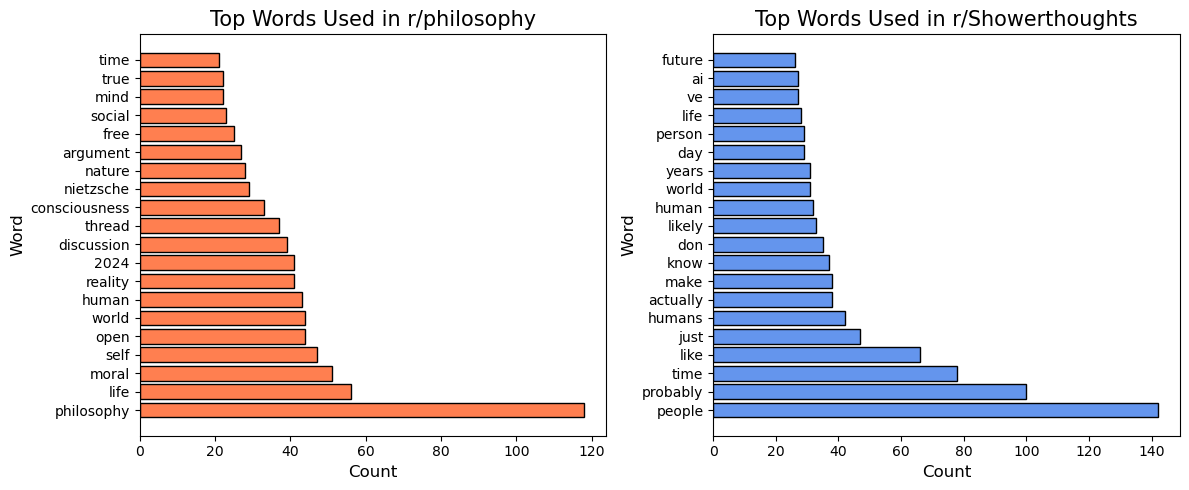

In [22]:
# Plotting the results from above

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].barh(top_words_philosophy.index, top_words_philosophy['Frequency'], color='coral', edgecolor = 'black')
axes[0].set_title('Top Words Used in r/philosophy', size = 15)
axes[0].set_xlabel('Count', size = 12)
axes[0].set_ylabel('Word', size = 12)

axes[1].barh(top_words_showerthoughts.index, top_words_showerthoughts['Frequency'], color='cornflowerblue', edgecolor = 'black')
axes[1].set_title('Top Words Used in r/Showerthoughts', size = 15)
axes[1].set_xlabel('Count', size = 12)
axes[1].set_ylabel('Word', size = 12)

plt.tight_layout()
plt.savefig('../images/top_words_by_subreddit.png')
plt.show();

- At a glance I can already see how post titles r/philosophy could have a more serious vocabulary compared to r/Showerthoughts
- r/Showerthoughts most frequent words (future, ai, like, people, probably) taking on a more uncertain tone, curious tone.

- Big buzz words found frequently in r/philosophy (moral, philosophy, nietzsche, conciousness) might allow these subreddits to be easily distinguished in our classification process.


**Using what I've found so far to revisit my problem statement: Is there a difference between our own self-made observations and those made by established philosophers?**
- A main difference I can hypothesize is that while the subject material may be very similar (life, knowledge, humanity), our own self-made observations tend to be less certain and less confident than those made by professional philosophers.

## Data Export

Now that we've ensured our data is properly formatted for processing, we can export this dataset and move on to the modelling stage.

In [19]:
reddit_titles.to_csv('../data/subreddit_data_cleaned.csv', index = None)